In [1]:
import dask
import distributed
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from xgcm import Grid

import warnings
import os,sys,time
import glob
import math
##warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
cluster = PBSCluster(
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=1:mem=50GB', # Specify resources
    project='NCGD0011', # Input your project ID here
    walltime='02:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)
cluster.scale(25)
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})
client=Client(cluster)
client

In [3]:
import ncar_jobqueue
import distributed

In [4]:
%%time
cluster = ncar_jobqueue.NCARCluster(
#    cores=9,  # The number of cores you want
    memory='500GB',  # Amount of memory
#    processes=9,  # How many processes
    walltime='06:00:00',  # Amount of wall time
    project="ncgd0011",  #Project id
)

cluster.scale(50)

/glade/u/home/pmora/.conda/envs/upwelling_post/lib/python3.10/site-packages/dask_jobqueue/core.py:251: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/u/home/pmora/.conda/envs/upwelling_post/lib/python3.10/site-packages/dask_jobqueue/core.py:270: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


CPU times: user 380 ms, sys: 35.7 ms, total: 416 ms
Wall time: 487 ms


/glade/u/home/pmora/.conda/envs/upwelling_post/lib/python3.10/site-packages/dask_jobqueue/core.py:251: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/u/home/pmora/.conda/envs/upwelling_post/lib/python3.10/site-packages/dask_jobqueue/core.py:270: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


In [13]:
client = distributed.Client(cluster)
client

<Client: 'tcp://10.12.206.33:42481' processes=19 threads=38, memory=475.00 GiB>

In [10]:
sclfac = 86400.
rho0 = 1.0e3
lonbeg = 270
lonend = 277
latbeg = 8
latend = 11.7

In [11]:
geometry_file = '/glade/scratch/bachman/ETP.012_tides3/run/ocean_geometry.nc'
dsg = xr.open_dataset(geometry_file)
dsg=dsg.rename({'lonh':'xh','lonq':'xq','lath':'yh','latq':'yq'})

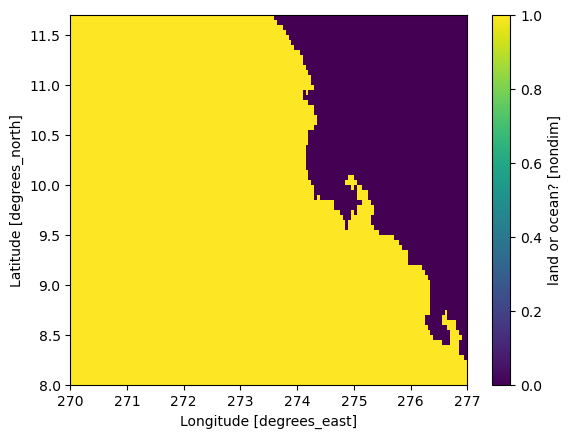

In [12]:
dsg['wet'].sel(xh=slice(lonbeg,lonend),yh=slice(latbeg,latend)).plot()

In [12]:
dsg

<xarray.Dataset>
Dimensions:  (yh: 900, xh: 1000, yq: 901, xq: 1001)
Coordinates:
  * yh       (yh) float64 -14.97 -14.93 -14.88 -14.82 ... 29.88 29.92 29.98
  * xh       (xh) float64 235.0 235.1 235.1 235.2 ... 284.8 284.9 284.9 285.0
  * yq       (yq) float64 -15.0 -14.95 -14.9 -14.85 ... 29.85 29.9 29.95 30.0
  * xq       (xq) float64 235.0 235.1 235.1 235.2 ... 284.9 284.9 284.9 285.0
Data variables: (12/19)
    geolatb  (yq, xq) float64 ...
    geolonb  (yq, xq) float64 ...
    geolat   (yh, xh) float64 ...
    geolon   (yh, xh) float64 ...
    D        (yh, xh) float64 ...
    f        (yq, xq) float64 ...
    ...       ...
    dyBu     (yq, xq) float64 ...
    Ah       (yh, xh) float64 ...
    Aq       (yq, xq) float64 ...
    dxCvo    (yq, xh) float64 ...
    dyCuo    (yh, xq) float64 ...
    wet      (yh, xh) float64 ...
Attributes:
    filename:  ./ocean_geometry.nc

In [23]:

ds_out_list = []
for year in range(1993,2019,1):
    print("reading year "+str(year)+"")
    path_in = '/glade/campaign/cgd/oce/people/bachman/ETP_1_20_tides/HOURLY/'
    date_str = 'ocean_hourly__'+str(year)+'_*'
    file_list = path_in + date_str + '.nc'
    files = sorted(glob.glob(file_list))

    ds = xr.open_mfdataset(files,
                           combine='nested',
                           compat='override',
                           coords='minimal',
                           parallel=True,
                           concat_dim="time")[["taux","tauy","sst","sss","wind_stress_curl_h" ]]
    print("processing year "+str(year)+"")
    
    DS = ds.sel(xh=slice(lonbeg,lonend),yh=slice(latbeg,latend), xq=slice(lonbeg,lonend),yq=slice(latbeg,latend))
    DS = DS.resample( time='1D').mean('time').persist()
    ds_out_list.append(DS.load())

print('concatenating segments')
ds_out = xr.concat(
ds_out_list,
dim="time",
coords="minimal",
compat="override",
).persist()

        
    
    
    


reading year 1993
processing year 1993
reading year 1994
processing year 1994
reading year 1995
processing year 1995
reading year 1996
processing year 1996
reading year 1997
processing year 1997
reading year 1998
processing year 1998
reading year 1999
processing year 1999
reading year 2000
processing year 2000
reading year 2001
processing year 2001
reading year 2002
processing year 2002
reading year 2003
processing year 2003
reading year 2004
processing year 2004
reading year 2005
processing year 2005
reading year 2006
processing year 2006
reading year 2007
processing year 2007
reading year 2008
processing year 2008
reading year 2009
processing year 2009
reading year 2010
processing year 2010
reading year 2011
processing year 2011
reading year 2012
processing year 2012
reading year 2013
processing year 2013
reading year 2014
processing year 2014
reading year 2015
processing year 2015
reading year 2016
processing year 2016
reading year 2017
processing year 2017
reading year 2018
process

In [24]:
ds_out

<xarray.Dataset>
Dimensions:             (time: 9522, yh: 74, xq: 141, yq: 75, xh: 140)
Coordinates:
  * xh                  (xh) float64 270.0 270.1 270.1 ... 276.9 276.9 277.0
  * yh                  (yh) float64 8.025 8.075 8.125 ... 11.57 11.62 11.68
  * xq                  (xq) float64 270.0 270.1 270.1 ... 276.9 276.9 277.0
  * yq                  (yq) float64 8.0 8.05 8.1 8.15 ... 11.55 11.6 11.65 11.7
  * time                (time) datetime64[ns] 1992-12-30 ... 2018-12-30
Data variables:
    taux                (time, yh, xq) float32 -0.0165 -0.01645 ... nan nan
    tauy                (time, yq, xh) float32 -0.01292 -0.01297 ... nan nan
    sst                 (time, yh, xh) float32 25.58 25.64 25.63 ... nan nan nan
    sss                 (time, yh, xh) float32 33.26 33.25 33.24 ... nan nan nan
    wind_stress_curl_h  (time, yh, xh) float32 1.067e-07 1.068e-07 ... nan nan
Attributes:
    NumFilesInSet:  1
    title:          MOM6 diagnostic fields table for CESM case: ETP.003
    grid_type:      regular
    grid_tile:      N/A

In [15]:
%%time
ds = xr.open_mfdataset(files,
                       combine='nested',
                       compat='override',
                       coords='minimal',
                       parallel=True,
                       chunks={'time': 312},
                       concat_dim="time")[["taux","tauy","sst","sss","wind_stress_curl_h" ]]

CPU times: user 1min 43s, sys: 3.4 s, total: 1min 47s
Wall time: 3min 12s


In [10]:
ds = ds.merge(dsg,compat='equals')

In [24]:
ds

<xarray.Dataset>
Dimensions:             (time: 227904, yh: 74, xq: 141, yq: 75, xh: 140)
Coordinates:
  * xh                  (xh) float64 270.0 270.1 270.1 ... 276.9 276.9 277.0
  * yh                  (yh) float64 8.025 8.075 8.125 ... 11.57 11.62 11.68
  * time                (time) datetime64[ns] 1992-12-30T01:00:00 ... 2018-12-30
  * xq                  (xq) float64 270.0 270.1 270.1 ... 276.9 276.9 277.0
  * yq                  (yq) float64 8.0 8.05 8.1 8.15 ... 11.55 11.6 11.65 11.7
Data variables:
    taux                (time, yh, xq) float32 dask.array<chunksize=(24, 74, 141), meta=np.ndarray>
    tauy                (time, yq, xh) float32 dask.array<chunksize=(24, 75, 140), meta=np.ndarray>
    sst                 (time, yh, xh) float32 dask.array<chunksize=(24, 74, 140), meta=np.ndarray>
    sss                 (time, yh, xh) float32 dask.array<chunksize=(24, 74, 140), meta=np.ndarray>
    wind_stress_curl_h  (time, yh, xh) float32 dask.array<chunksize=(24, 74, 140), meta=np.ndarray>
Attributes:
    NumFilesInSet:  1
    title:          MOM6 diagnostic fields table for CESM case: ETP.003
    grid_type:      regular
    grid_tile:      N/A

In [20]:

ds = ds.sel(xh=slice(lonbeg,lonend),yh=slice(latbeg,latend), xq=slice(lonbeg,lonend),yq=slice(latbeg,latend))

In [69]:
#range_year = 
ds.where(ds["time"]==1992, ds)
#newds=ds.isel(range_year)

<xarray.Dataset>
Dimensions:             (time: 227904, yh: 74, xq: 141, yq: 75, xh: 140)
Coordinates:
  * xh                  (xh) float64 270.0 270.1 270.1 ... 276.9 276.9 277.0
  * yh                  (yh) float64 8.025 8.075 8.125 ... 11.57 11.62 11.68
  * time                (time) datetime64[ns] 1992-12-30T01:00:00 ... 2018-12-30
  * xq                  (xq) float64 270.0 270.1 270.1 ... 276.9 276.9 277.0
  * yq                  (yq) float64 8.0 8.05 8.1 8.15 ... 11.55 11.6 11.65 11.7
Data variables:
    taux                (time, yh, xq) float32 dask.array<chunksize=(24, 74, 141), meta=np.ndarray>
    tauy                (time, yq, xh) float32 dask.array<chunksize=(24, 75, 140), meta=np.ndarray>
    sst                 (time, yh, xh) float32 dask.array<chunksize=(24, 74, 140), meta=np.ndarray>
    sss                 (time, yh, xh) float32 dask.array<chunksize=(24, 74, 140), meta=np.ndarray>
    wind_stress_curl_h  (time, yh, xh) float32 dask.array<chunksize=(24, 74, 140), meta=np.ndarray>
Attributes:
    NumFilesInSet:  1
    title:          MOM6 diagnostic fields table for CESM case: ETP.003
    grid_type:      regular
    grid_tile:      N/A

In [68]:
tlen = len(ds['time'])
print(tlen)
time_step = 365*24

227904


In [ ]:
for time_ind0 in range(48, tlen, time_step):
    print(f"time_ind={time_ind0}, {time_ind0 + time_step}")
    da_in = ds.isel(
                    {'time': slice(time_ind0, time_ind0 + time_step)}
                )
    print(da_in['time'].values)
    

In [ ]:
ds = ds.groupby('time.day*').mean('time') #.persist()

In [ ]:
DS = ds.resample( time='1D').mean('time').persist()

In [ ]:
ds.chunks

In [14]:
ds

<xarray.Dataset>
Dimensions:             (time: 227904, yh: 74, xq: 141, yq: 75, xh: 140)
Coordinates:
  * xh                  (xh) float64 270.0 270.1 270.1 ... 276.9 276.9 277.0
  * yh                  (yh) float64 8.025 8.075 8.125 ... 11.57 11.62 11.68
  * time                (time) datetime64[ns] 1992-12-30T01:00:00 ... 2018-12-30
  * xq                  (xq) float64 270.0 270.1 270.1 ... 276.9 276.9 277.0
  * yq                  (yq) float64 8.0 8.05 8.1 8.15 ... 11.55 11.6 11.65 11.7
Data variables:
    taux                (time, yh, xq) float32 dask.array<chunksize=(24, 74, 141), meta=np.ndarray>
    tauy                (time, yq, xh) float32 dask.array<chunksize=(24, 75, 140), meta=np.ndarray>
    sst                 (time, yh, xh) float32 dask.array<chunksize=(24, 74, 140), meta=np.ndarray>
    sss                 (time, yh, xh) float32 dask.array<chunksize=(24, 74, 140), meta=np.ndarray>
    wind_stress_curl_h  (time, yh, xh) float32 dask.array<chunksize=(24, 74, 140), meta=np.ndarray>
Attributes:
    NumFilesInSet:  1
    title:          MOM6 diagnostic fields table for CESM case: ETP.003
    grid_type:      regular
    grid_tile:      N/A

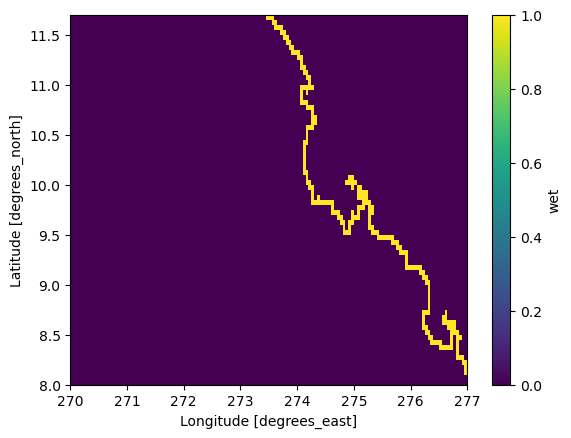

In [19]:
wet = dsg['wet'].astype('int')
land = 1 - wet
e = land.shift(xh=-1,fill_value=1)
w = land.shift(xh=1,fill_value=0)
n = land.shift(yh=-1,fill_value=0)
s = land.shift(yh=1,fill_value=0)
ne = n.shift(xh=-1,fill_value=1)
nw = n.shift(xh=1,fill_value=0)
se = s.shift(xh=-1,fill_value=0)
sw = s.shift(xh=1,fill_value=0)
neighbors = n + s + e + w + ne + nw + se + sw
coast = neighbors*dsg['wet']
coast = xr.where(coast >= 1,1,0)
ocean = dsg['wet'] - coast
coast.sel(xh=slice(lonbeg,lonend),yh=slice(latbeg,latend)).plot()

In [29]:
grid = Grid(ds_out, 
            coords={'X': {'center': 'xh', 'outer': 'xq'},
                    'Y': {'center': 'yh', 'outer': 'yq'},
                    },
            periodic=None
           )

In [17]:

ds_out_list = []
for year in range(1993,2019,1):
    print("reading year "+str(year)+"")
    path_in = '/glade/campaign/cgd/oce/people/bachman/ETP_1_20_tides/HOURLY/'
    date_str = 'ocean_hourly__'+str(year)+'_*'
    file_list = path_in + date_str + '.nc'
    files = sorted(glob.glob(file_list))

    ds = xr.open_mfdataset(files,
                           combine='nested',
                           compat='override',
                           coords='minimal',
                           parallel=True,
                           concat_dim="time")[["taux","tauy","sst","sss","wind_stress_curl_h" ]]
    print("processing year "+str(year)+"")
    
    DS = ds.sel(xh=slice(lonbeg,lonend),yh=slice(latbeg,latend), xq=slice(lonbeg,lonend),yq=slice(latbeg,latend))
    DS = DS.resample( time='1D').mean('time').persist()
    ds_out_list.append(DS.load())
    
ds_out = xr.concat(
ds_out_list,
dim="time",
coords="minimal",
compat="override",
).persist()

        
    
    
    


reading year 1993
processing year 1993
reading year 1994
processing year 1994


In [25]:
taux = ds_out['taux'].fillna(0.)

In [26]:
tauy = ds_out['tauy'].fillna(0.)

In [30]:
taux_at_q = grid.interp(taux,'Y',boundary='extend')

In [31]:
tauy_at_q = grid.interp(tauy,'X',boundary='extend')

taux_at_q= taux.interp(yh=ds["yq"],
    kwargs={"fill_value": "extrapolate"}) 
taux_at_q = taux_at_q.drop_vars('yh')
taux_at_q 

tauy_at_q= tauy.interp(xh=ds["xq"],
    kwargs={"fill_value": "extrapolate"}) 
tauy_at_q= tauy_at_q.drop_vars('xh')
tauy_at_q

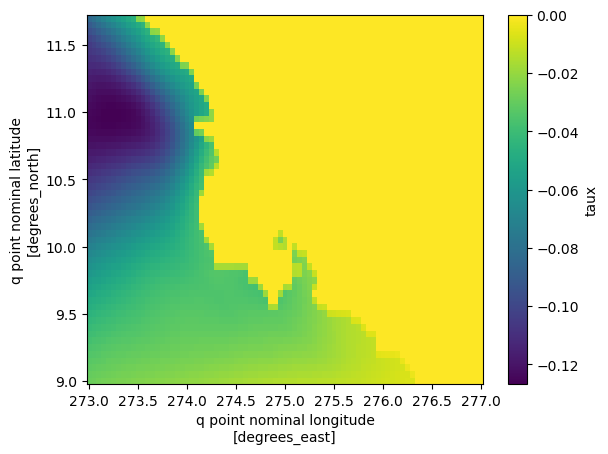

In [22]:
taux_at_q.mean('time').sel(xq=slice(lonbeg,lonend),yq=slice(latbeg,latend)).plot()

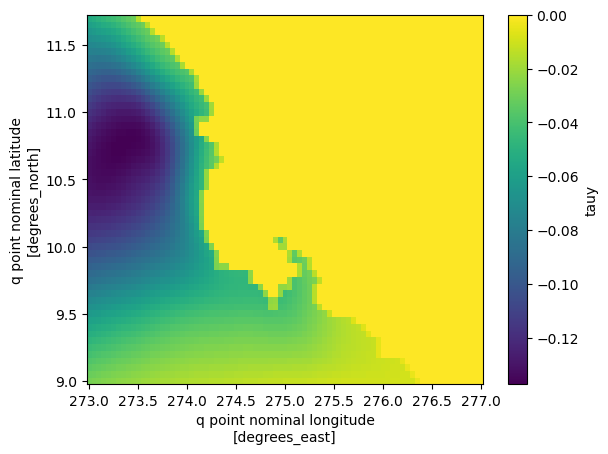

In [23]:
tauy_at_q.mean('time').sel(xq=slice(lonbeg,lonend),yq=slice(latbeg,latend)).plot()

In [32]:
j_eq = (np.abs(dsg['yq'])).argmin().values
#print(j_eq,dsg['yq'][j_eq].values,dsg['f'][j_eq,0].values)

In [70]:
Uek_at_q =  tauy_at_q/(rho0*dsg['f'])
Uek_at_q = Uek_at_q.where(np.isfinite(Uek_at_q),0.)
Vek_at_q = -taux_at_q/(rho0*dsg['f'])
Vek_at_q = Vek_at_q.where(np.isfinite(Vek_at_q),0.)

In [71]:
Uek_at_u = grid.interp(Uek_at_q,'Y',boundary='extend')

In [72]:
Vek_at_v = grid.interp(Vek_at_q,'X',boundary='extend')

Uek_at_u= Uek_at_q.interp(yq=ds["yh"],method='nearest',
    kwargs={"fill_value": "extrapolate"})
Uek_at_u= Uek_at_u.drop_vars({'yq'})
Uek_at_u

Vek_at_v= Vek_at_q.interp(xq=ds["xh"],method='nearest',
    kwargs={"fill_value": "extrapolate"}) 
Vek_at_v=Vek_at_v.drop_vars({'xq'})
Vek_at_v

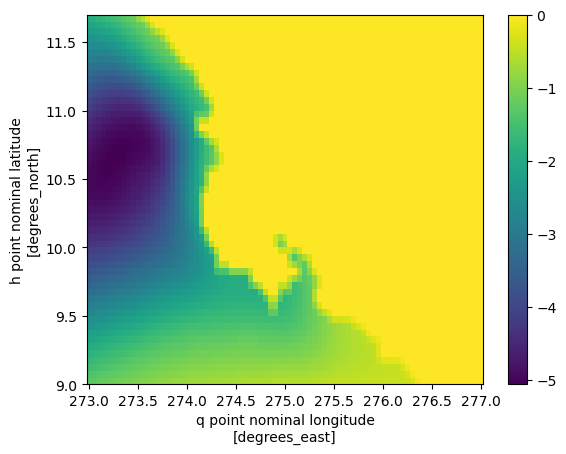

In [26]:
Uek_at_u.mean('time').sel(xq=slice(lonbeg,lonend),yh=slice(latbeg,latend)).plot()

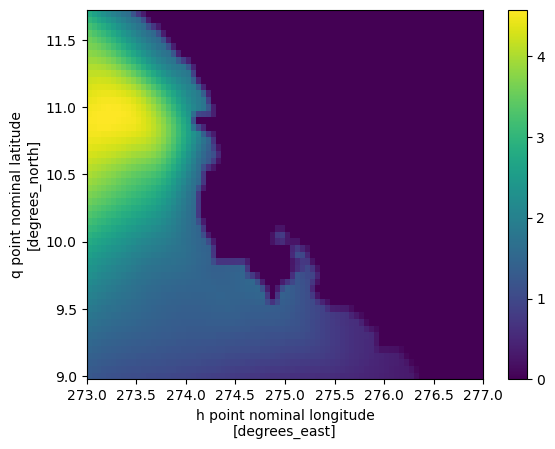

In [27]:

Vek_at_v.mean('time').sel(xh=slice(lonbeg,lonend),yq=slice(latbeg,latend)).plot()

In [73]:

Uek_at_u = Uek_at_u.fillna(0.)
Vek_at_v = Vek_at_v.fillna(0.)

In [74]:

Wek_u = ((grid.diff(Uek_at_u*dsg['dyCu'],'X',boundary='fill'))/dsg['Ah'])*dsg['wet']

In [76]:

Wek_v = ((grid.diff(Vek_at_v*dsg['dxCv'],'Y',boundary='fill'))/dsg['Ah'])*dsg['wet']

In [77]:
Wek = (Wek_u + Wek_v)

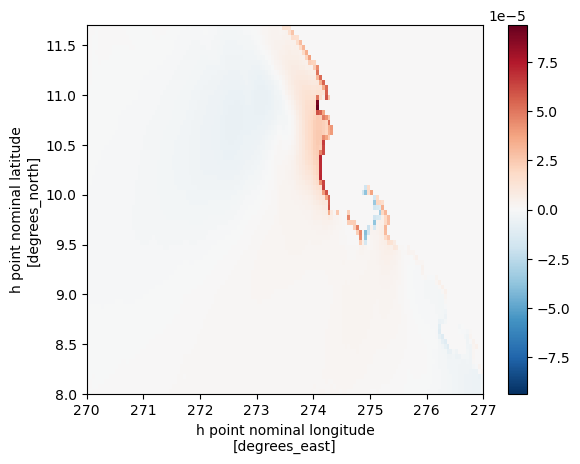

In [42]:
Wek_u.mean('time').sel(xh=slice(lonbeg,lonend),yh=slice(latbeg,latend)).plot()

Wek_v= (Vek_at_v*dsg['dxCv']).interp(yq=ds["yh"],
    kwargs={"fill_value": "extrapolate"})
Wek_v=(Wek_v/dsg['Ah'])*dsg['wet']
Wek_v=Wek_v.drop_vars({'yq'})
Wek_v

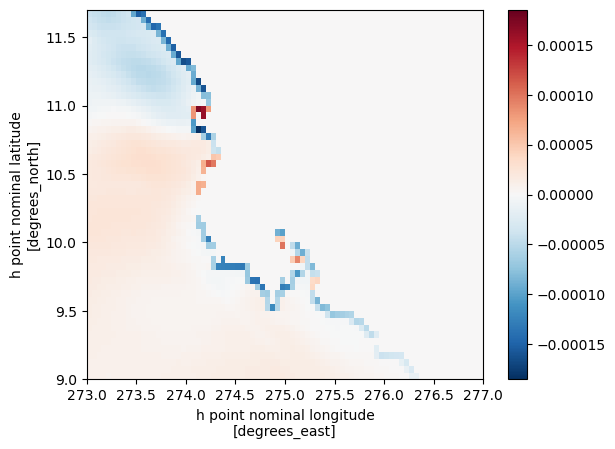

In [30]:
Wek_v.mean('time').sel(xh=slice(lonbeg,lonend),yh=slice(latbeg,latend)).plot()

In [78]:
Uek_at_u = Uek_at_u.load()
Vel_at_v=Vel_at_v.load()
Wek=Wek.load()
Wek_u=Wek_u.load()
Wek_v= Wek_v.load()

In [49]:
ds_out = xr.Dataset()
ds_out['wet'] = wet
ds_out['mask_coast'] = coast
ds_out['mask_openocean'] = ocean

In [84]:
UVek_out = xr.Dataset()
Uek_at_u = Uek_at_u.astype('float32')
Uek_at_u.attrs = {'long_name':'Zonal Ekman transport on east face of h cell','units':'m^2/s'}
Vel_at_v = Vek_at_v.astype('float32')
Vek_at_v.attrs = {'long_name':'Meridional Ekman transport on north face of h cell','units':'m^2/s'}
#ds_out['Uek'] = Uek_at_u

UVek_out['Uek'] = Uek_at_u
UVek_out['Vek'] = Vek_at_v

#Uek_at_u = Uek_at_u.rename({'__xarray_dataarray_variable__': 'Ep'})
UVek_out =UVek_out.to_netcdf('/glade/scratch/pmora/UVek.nc')

In [87]:
UVek_out

In [89]:
Wek_out = xr.Dataset()
Wek = Wek.astype('float32')
Wek.attrs = {'long_name':'Total Ekman upwelling','units':'m/s'}
Wek_out['Wek'] = Wek

Wek_u = Wek_u.astype('float32')
Wek_u.attrs = {'long_name':'Ekman upwelling due to zonal divergence','units':'m/s'}
Wek_out['Wek_u'] = Wek_u

Wek_v = Wek_v.astype('float32')
Wek_v.attrs = {'long_name':'Ekman upwelling due to meridional divergence','units':'m/s'}
Wek_out['Wek_v'] = Wek_v

Wek_out =Wek_out.to_netcdf('/glade/scratch/pmora/Wek_daily_F.nc')
Wek_out

In [ ]:
Wekt = ds_out.to_netcdf('/glade/scratch/pmora/Upwelling_CR.nc')

In [ ]:
ds_out['Wek'].mean('time').sel(xh=slice(lonbeg,lonend),yh=slice(latbeg,latend)).plot()

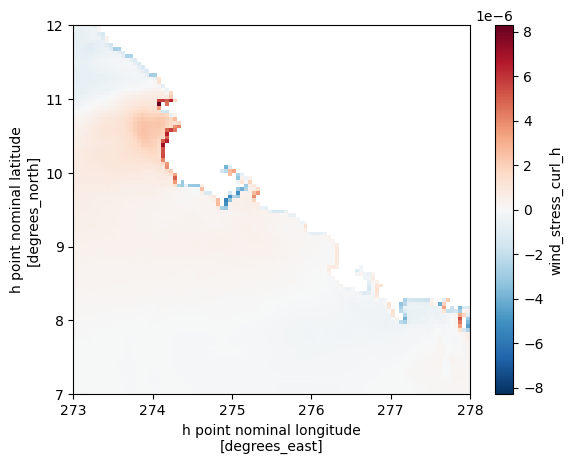

In [52]:
ds['wind_stress_curl_h'].mean('time').sel(xh=slice(lonbeg,lonend),yh=slice(latbeg,latend)).plot()

In [51]:
sclfac = 86400.
lonbeg = 273
lonend = 278
latbeg = 7
latend = 12

In [50]:
ds_out = xr.Dataset()
ds_out['wet'] = dsg['wet']
ds_out['mask_coast'] = coast
ds_out['mask_openocean'] = ocean
ds_out['Uek'] = Uek_at_u
ds_out['Vek'] = Vek_at_v
ds_out['Wek'] = Wek
ds_out['Wek_u'] = Wek_u
ds_out['Wek_v'] = Wek_v
ds_out.to_netcdf('/glade/scratch/pmora/test_ekman.nc')

In [33]:
Wek_mean = Wek.mean('time') #.compute()

In [93]:
Wek_month_out = xr.Dataset()


Wek_month= Wek.groupby('time.month').mean('time').persist()
Wek_month =Wek_month.astype('float32')
Wek_month.attrs = {'long_name':'Total Ekman upwelling','units':'m/s'}
Wek_month_out['Wek'] = Wek_month

Wek_u_month= Wek_u.groupby('time.month').mean('time').persist()
Wek_u_month = Wek_u_month.astype('float32')
Wek_u_month.attrs = {'long_name':'Ekman upwelling due to zonal divergence','units':'m/s'}
Wek_month_out['Wek_u'] = Wek_u_month

Wek_v_month= Wek_v.groupby('time.month').mean('time').persist()
Wek_v_month = Wek_v_month.astype('float32')
Wek_v_month.attrs = {'long_name':'Ekman upwelling due to meridional divergence','units':'m/s'}
Wek_month_out['Wek_v'] = Wek_v_month


Wek_out =Wek_month_out.to_netcdf('/glade/scratch/pmora/Wek_month_F.nc')
Wek_out



In [94]:
Wek_month_out

<xarray.Dataset>
Dimensions:  (yh: 74, xh: 140, month: 12)
Coordinates:
  * yh       (yh) float64 8.025 8.075 8.125 8.175 ... 11.52 11.57 11.62 11.68
  * xh       (xh) float64 270.0 270.1 270.1 270.2 ... 276.8 276.9 276.9 277.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    Wek      (month, yh, xh) float32 4.386e-07 2.407e-07 3.036e-07 ... 0.0 0.0
    Wek_u    (month, yh, xh) float32 -2.429e-07 -4.921e-07 ... 0.0 0.0
    Wek_v    (month, yh, xh) float32 6.815e-07 7.328e-07 7.851e-07 ... 0.0 0.0

In [55]:
Uek_at_uo =Uek_at_u.to_netcdf('/glade/scratch/pmora/Uek.nc')
Vek_at_vo =Vek_at_v.to_netcdf('/glade/scratch/pmora/Vek.nc')

In [ ]:
Wekt_month = Wek_month.to_netcdf('/glade/scratch/pmora/Wekt_month_F.nc')


In [34]:
Wek_u_mean =Wek_u.mean('time') #.compute()

In [35]:
Wek_v_mean =Wek_v.mean('time') #.compute()

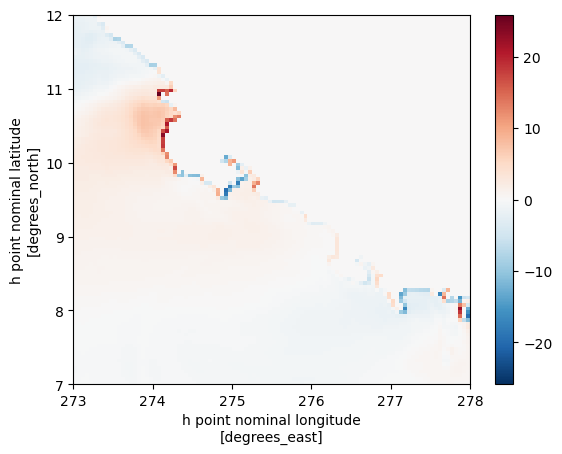

In [36]:
(sclfac*Wek_mean).sel(xh=slice(lonbeg,lonend),yh=slice(latbeg,latend)).plot()

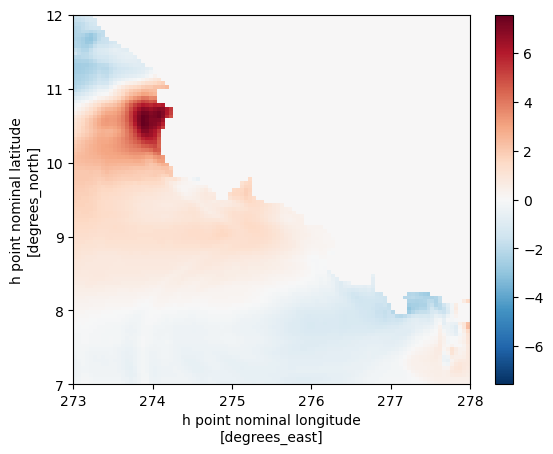

In [38]:
(sclfac*Wek_mean*ocean).sel(xh=slice(lonbeg,lonend),yh=slice(latbeg,latend)).plot()

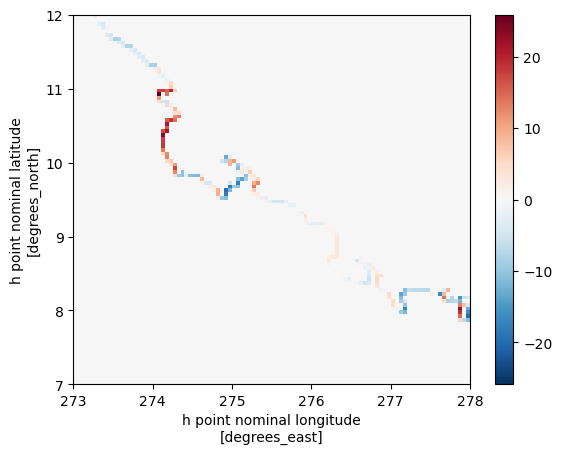

In [37]:
(sclfac*Wek_mean*coast).sel(xh=slice(lonbeg,lonend),yh=slice(latbeg,latend)).plot()

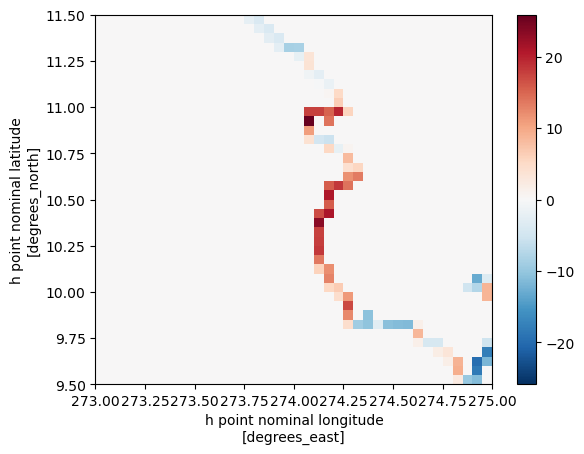

In [39]:
(sclfac*Wek_mean*coast).sel(xh=slice(273,275),yh=slice(9.5,11.5)).plot()

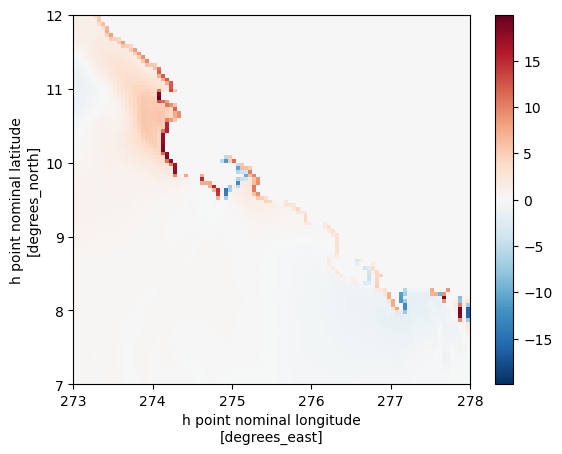

In [40]:
(sclfac*Wek_u_mean).sel(xh=slice(lonbeg,lonend),yh=slice(latbeg,latend)).plot()

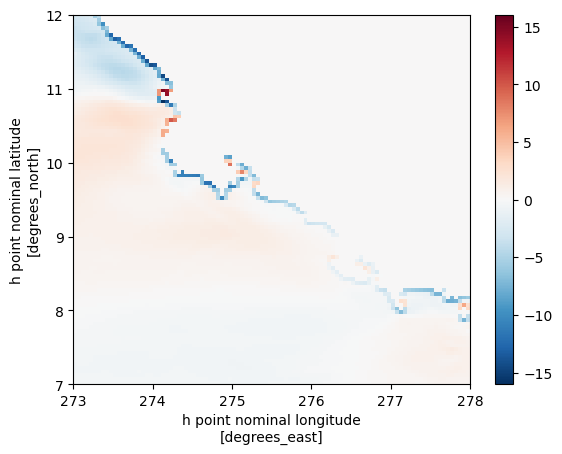

In [41]:
(sclfac*Wek_v_mean).sel(xh=slice(lonbeg,lonend),yh=slice(latbeg,latend)).plot()

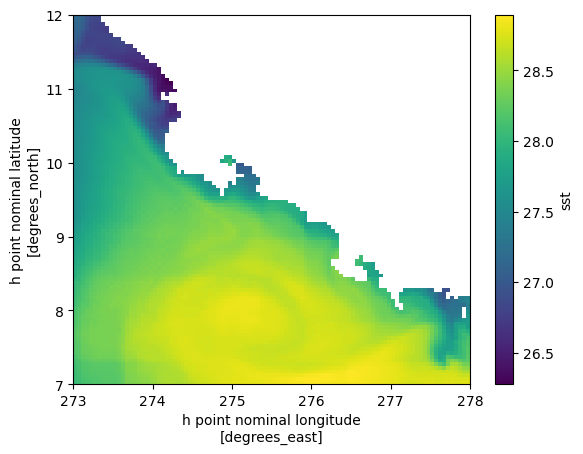

In [42]:
ds['sst'].sel(xh=slice(lonbeg,lonend),yh=slice(latbeg,latend)).mean('time').plot()

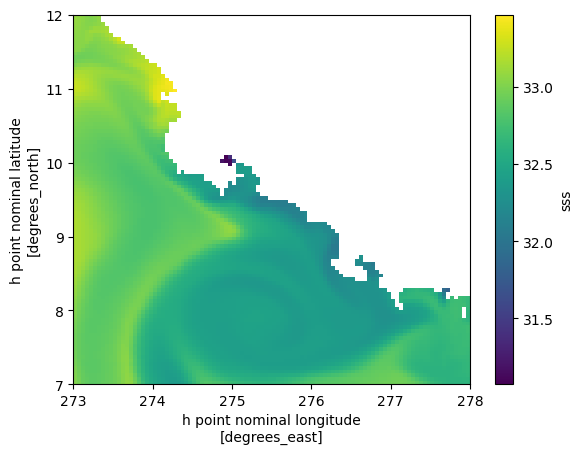

In [43]:
ds['sss'].sel(xh=slice(lonbeg,lonend),yh=slice(latbeg,latend)).mean('time').plot()

In [ ]:
time = ds['time']#/(24.0*365.)
lonplt = 274.
latplt = 11

lon_title = '{:.1f}''{:3s}'.format(lonplt,'$^\circ$E ')
lat_title = '{:.1f}''{:3s}'.format(latplt,'$^\circ$N ')
title = lon_title + ' / ' + lat_title

fig,ax=plt.subplots(nrows=5,sharex=True,constrained_layout=True,figsize=(10,8))
fig.suptitle(title)

ax[0].plot(time,taux.sel(xq=lonplt,yh=latplt,method='nearest'),label=r'$\tau^{x}$')
ax[0].plot(time,tauy.sel(xh=lonplt,yq=latplt,method='nearest'),label=r'$\tau^{y}$')
ax[0].legend()
ax[0].set_title('Windstress')

ax[1].plot(time,Uek_at_u.sel(xq=lonplt,yh=latplt,method='nearest'),label='Uek')
ax[1].plot(time,Vek_at_v.sel(xh=lonplt,yq=latplt,method='nearest'),label='Vek')
ax[1].legend()
ax[1].set_title('Ekman Transport')

ax[2].plot(time,(sclfac*Wek).sel(xh=lonplt,yh=latplt,method='nearest'),label='Wek')
ax[2].plot(time,(sclfac*Wek_u).sel(xh=lonplt,yh=latplt,method='nearest'),label='Wek_U')
ax[2].plot(time,(sclfac*Wek_v).sel(xh=lonplt,yh=latplt,method='nearest'),label='Wek_V')
ax[2].legend()
ax[2].set_title('Ekman Pumping')
                    
ax[3].plot(time,ds['sst'].sel(xh=lonplt,yh=latplt,method='nearest'))
ax[3].set_title('SST')

ax[4].plot(time,ds['sss'].sel(xh=lonplt,yh=latplt,method='nearest'))
ax[4].set_title('SSS');

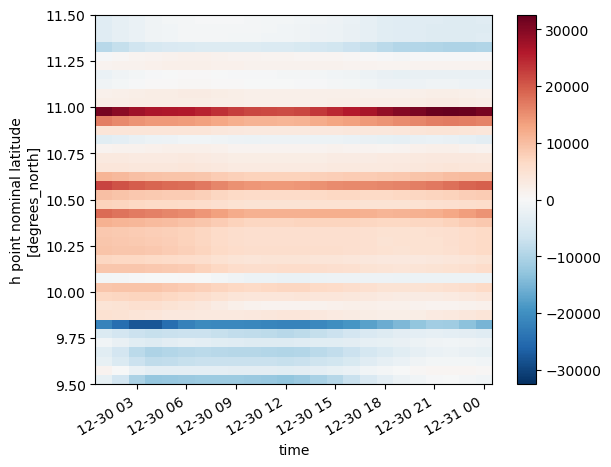

In [44]:
coast_upwell_T = (Wek*dsg['Ah']*coast).sel(xh=slice(270,285),yh=slice(9.5,11.5)).sum(dim={'xh'})
coast_upwell_T.T.plot()
# Transport m3/s

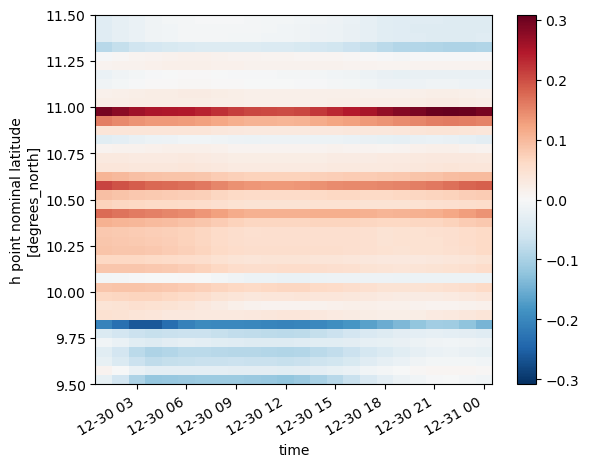

In [45]:
coast_upwell_W = (sclfac*Wek*coast).sel(xh=slice(270,285),yh=slice(9.5,11.5)).mean(dim={'xh'})
coast_upwell_W.T.plot()
# MEAN_VEL m/day

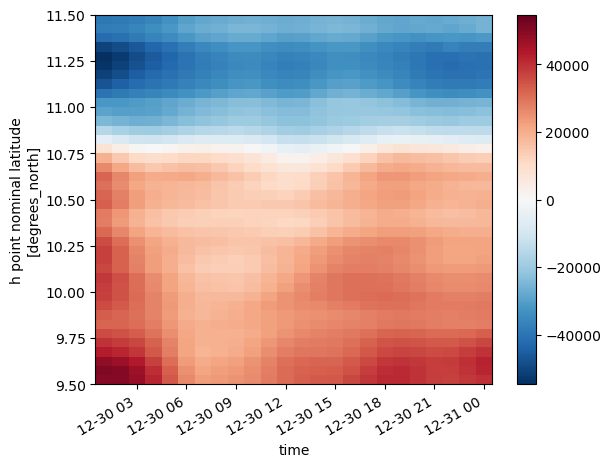

In [46]:
ocean_upwell_T = (Wek*dsg['Ah']*ocean).sel(xh=slice(270,285),yh=slice(9.5,11.5)).sum(dim={'xh'})
ocean_upwell_T.T.plot()
# Transport m3/s

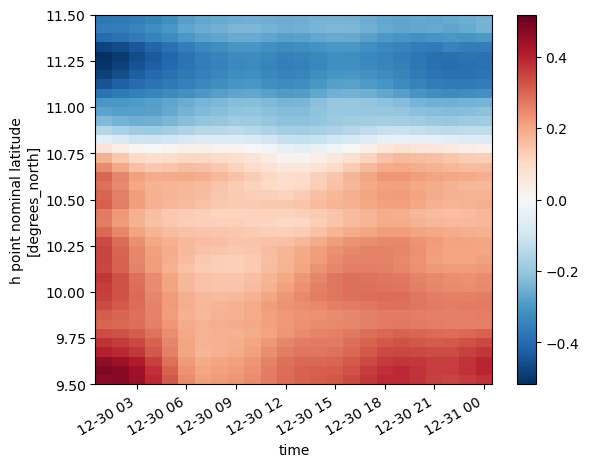

In [47]:
ocean_upwell_W = (sclfac*Wek*ocean).sel(xh=slice(270,285),yh=slice(9.5,11.5)).mean(dim={'xh'})
ocean_upwell_W.T.plot()
# MEAN_VEL m/day

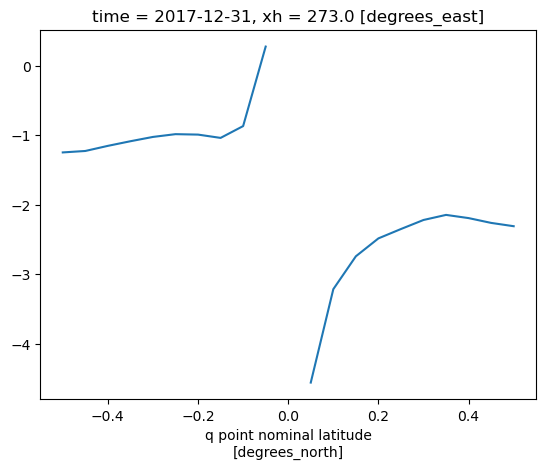

In [48]:
Vek_at_v.isel(time=-1).sel(xh=lonbeg,method='nearest').sel(yq=slice(-0.5,0.5)).plot()

In [49]:
Vek_at_v[0,298:301,0].values

array([-164.82321932, -332.73953213,           inf])

In [40]:
client.shutdown()

In [43]:
client.close()
cluster.close()